### Data Loading

In [201]:
import os
import torch
import librosa
import numpy as np
from tqdm import tqdm

emotion_dict = {
    # '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def get_emotion_label(filename):
    try:
        emotion_code = filename.split('-')[2]
        return emotion_dict.get(emotion_code)
    except:
        return None

def extract_features(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    rms = librosa.feature.rms(y=y)
    return np.vstack([mfcc, delta, delta2, rms]).T  # shape: (timesteps, 121)

#Load dataset
X = []
y = []

flat_folder = "AUDIO_MIX"

for file in tqdm(os.listdir(flat_folder)):
    if not file.endswith(".wav"):
        continue

    label = get_emotion_label(file)
    if label is None:
        continue

    file_path = os.path.join(flat_folder, file)
    y_raw, sr = librosa.load(file_path, sr=22050)
    y_trimmed, _ = librosa.effects.trim(y_raw)

    features = extract_features(y_trimmed, sr)  # Keep (T, 121)
    X.append(features)
    y.append(label)

y = np.array(y)  # Convert labels to numpy array for later processing

100%|██████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:40<00:00, 60.80it/s]


In [221]:
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, X, y):
        if not isinstance(X, torch.Tensor):
            self.X = torch.tensor(X, dtype=torch.float32)
        else:
            self.X = X.float()

        if not isinstance(y, torch.Tensor):
            self.y = torch.tensor(y, dtype=torch.long)
        else:
            self.y = y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [223]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Convert list of (timesteps × features) arrays to list of tensors
X_tensor_list = [torch.tensor(x, dtype=torch.float32) for x in X]

# Pad to the same length (max timesteps) with zeros at the end (post-padding)
X_padded = pad_sequence(X_tensor_list, batch_first=True)  # shape: (N, T, F)

# Convert labels to numpy array if not already
y = np.array(y)

In [224]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Optional: Save mapping
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label encoding:", label_map)

Label encoding: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'sad': 5, 'surprised': 6}


In [229]:
    from collections import defaultdict
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader
    
    # Group indices by class
    class_indices = defaultdict(list)
    for idx, label in enumerate(y_encoded):
        class_indices[label].append(idx)
    
    # Balanced sampling
    train_indices = []
    val_indices = []
    
    for label, indices in class_indices.items():
        train_ids, val_ids = train_test_split(indices, test_size=0.2, random_state=42)
        train_indices.extend(train_ids)
        val_indices.extend(val_ids)
    
    # Create balanced datasets
    X_train = X_padded[train_indices]
    y_train = y_encoded[train_indices]

################

from librosa.effects import pitch_shift, preemphasis

# Re-enhance only 'neutral' class (label == 5) samples in training set
for i, global_idx in enumerate(train_indices):
 if y[global_idx] == 5:  # Check original label (before encoding)
        file_name = file_names[global_idx]
        file_path = os.path.join(flat_folder, file_name)

        y_raw, sr = librosa.load(file_path, sr=22050)
        y_trimmed, _ = librosa.effects.trim(y_raw)
        y_trimmed = pitch_shift(y_trimmed, sr, n_steps=1)
        y_trimmed = preemphasis(y_trimmed)

        enhanced_features = extract_features(y_trimmed, sr)
        padded = pad_sequence(torch.tensor(enhanced_features).unsqueeze(0), batch_first=True)

        X_train[i] = padded.squeeze(0)





    X_val = X_padded[val_indices]
    y_val = y_encoded[val_indices]

    # Create PyTorch datasets
    train_dataset = EmotionDataset(X_train, y_train)
    val_dataset = EmotionDataset(X_val, y_val)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Model Definition

In [237]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)  # Bidirectional LSTM

    def forward(self, lstm_out):
        # lstm_out: (batch, time, hidden*2)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # (batch, time, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)       # (batch, hidden*2)
        return context

class EmotionCNNBiLSTM(nn.Module):
    def __init__(self, input_dim=121, cnn_out=64, lstm_hidden=128, num_classes=7):
        super(EmotionCNNBiLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_out),
            nn.MaxPool1d(kernel_size=2)
        )
        self.lstm = nn.LSTM(input_size=cnn_out, hidden_size=lstm_hidden,
                            num_layers=1, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim=lstm_hidden)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, x):
        # x: (batch, time, features)
        x = x.permute(0, 2, 1)              # -> (batch, features, time)
        x = self.cnn(x)                     # -> (batch, cnn_out, time//2)
        x = x.permute(0, 2, 1)              # -> (batch, time, cnn_out)
        lstm_out, _ = self.lstm(x)          # -> (batch, time, hidden*2)
        context = self.attention(lstm_out)  # -> (batch, hidden*2)
        out = self.fc(context)              # -> (batch, num_classes)
        return out

In [239]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionCNNBiLSTM(input_dim=121, cnn_out=64, lstm_hidden=128, num_classes=7)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### With Neutral

In [195]:
target_loss = 0.62
epoch = 0

while True:
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    epoch += 1
    print(f"Epoch {epoch} - Loss: {train_loss:.4f}")

    if train_loss <= target_loss:
        print(f"✅ Training stopped at epoch {epoch} with loss {train_loss:.4f} (≤ {target_loss})")
        break

Epoch 1 - Loss: 107.5164
Epoch 2 - Loss: 77.5954
Epoch 3 - Loss: 62.8947
Epoch 4 - Loss: 53.2308
Epoch 5 - Loss: 45.6961
Epoch 6 - Loss: 43.0177
Epoch 7 - Loss: 35.8779
Epoch 8 - Loss: 30.1266
Epoch 9 - Loss: 28.8482
Epoch 10 - Loss: 28.7815
Epoch 11 - Loss: 21.9707
Epoch 12 - Loss: 17.7066
Epoch 13 - Loss: 14.5640
Epoch 14 - Loss: 17.5268
Epoch 15 - Loss: 16.0290
Epoch 16 - Loss: 14.2415
Epoch 17 - Loss: 7.8069
Epoch 18 - Loss: 4.9473
Epoch 19 - Loss: 3.8585
Epoch 20 - Loss: 7.4865
Epoch 21 - Loss: 6.3227
Epoch 22 - Loss: 5.3935
Epoch 23 - Loss: 3.8894
Epoch 24 - Loss: 9.6650
Epoch 25 - Loss: 5.6026
Epoch 26 - Loss: 21.4856
Epoch 27 - Loss: 6.6826
Epoch 28 - Loss: 2.7237
Epoch 29 - Loss: 1.3864
Epoch 30 - Loss: 3.6006
Epoch 31 - Loss: 11.3596
Epoch 32 - Loss: 4.2857
Epoch 33 - Loss: 2.1687
Epoch 34 - Loss: 1.0950
Epoch 35 - Loss: 0.5978
✅ Training stopped at epoch 35 with loss 0.5978 (≤ 0.62)


In [197]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

# Metrics
print("✅ Overall Accuracy:", accuracy_score(all_labels, all_preds) * 100)
print("✅ Weighted F1 Score:", f1_score(all_labels, all_preds, average='weighted') * 100)
print("✅ Per Class Accuracy:")

import numpy as np
labels = np.unique(all_labels)
for label in labels:
    correct = sum((np.array(all_preds) == label) & (np.array(all_labels) == label))
    total = sum(np.array(all_labels) == label)
    acc = 100 * correct / total if total > 0 else 0
    print(f"   {label}: {acc:.2f}%")

✅ Overall Accuracy: 82.86290322580645
✅ Weighted F1 Score: 82.7966227377242
✅ Per Class Accuracy:
   0: 90.79%
   1: 94.74%
   2: 79.49%
   3: 76.32%
   4: 81.58%
   5: 68.42%
   6: 78.95%
   7: 84.62%


### Without Neutral

In [241]:
target_loss = 0.5
epoch = 0

while True:
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    epoch += 1
    print(f"Epoch {epoch} - Loss: {train_loss:.4f}")

    if train_loss <= target_loss:
        print(f"✅ Training stopped at epoch {epoch} with loss {train_loss:.4f} (≤ {target_loss})")
        break

Epoch 1 - Loss: 91.4108
Epoch 2 - Loss: 67.4256
Epoch 3 - Loss: 52.9592
Epoch 4 - Loss: 43.7181
Epoch 5 - Loss: 38.9742
Epoch 6 - Loss: 31.6324
Epoch 7 - Loss: 29.1389
Epoch 8 - Loss: 29.0103
Epoch 9 - Loss: 21.6045
Epoch 10 - Loss: 18.8770
Epoch 11 - Loss: 15.8109
Epoch 12 - Loss: 12.6031
Epoch 13 - Loss: 15.2521
Epoch 14 - Loss: 10.6168
Epoch 15 - Loss: 8.5157
Epoch 16 - Loss: 7.5708
Epoch 17 - Loss: 5.7641
Epoch 18 - Loss: 4.7310
Epoch 19 - Loss: 3.2244
Epoch 20 - Loss: 3.5903
Epoch 21 - Loss: 4.3181
Epoch 22 - Loss: 2.5122
Epoch 23 - Loss: 2.8631
Epoch 24 - Loss: 3.4376
Epoch 25 - Loss: 2.5916
Epoch 26 - Loss: 3.8042
Epoch 27 - Loss: 3.1496
Epoch 28 - Loss: 1.3514
Epoch 29 - Loss: 0.8918
Epoch 30 - Loss: 5.0084
Epoch 31 - Loss: 4.0364
Epoch 32 - Loss: 2.8830
Epoch 33 - Loss: 1.3983
Epoch 34 - Loss: 0.4678
✅ Training stopped at epoch 34 with loss 0.4678 (≤ 0.5)


In [243]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

# Metrics
print("✅ Overall Accuracy:", accuracy_score(all_labels, all_preds) * 100)
print("✅ Weighted F1 Score:", f1_score(all_labels, all_preds, average='weighted') * 100)
print("✅ Per Class Accuracy:")

import numpy as np
labels = np.unique(all_labels)
for label in labels:
    correct = sum((np.array(all_preds) == label) & (np.array(all_labels) == label))
    total = sum(np.array(all_labels) == label)
    acc = 100 * correct / total if total > 0 else 0
    print(f"   {label}: {acc:.2f}%")

✅ Overall Accuracy: 83.4061135371179
✅ Weighted F1 Score: 83.41116487853209
✅ Per Class Accuracy:
   0: 89.47%
   1: 96.05%
   2: 89.74%
   3: 76.32%
   4: 77.63%
   5: 77.63%
   6: 76.92%


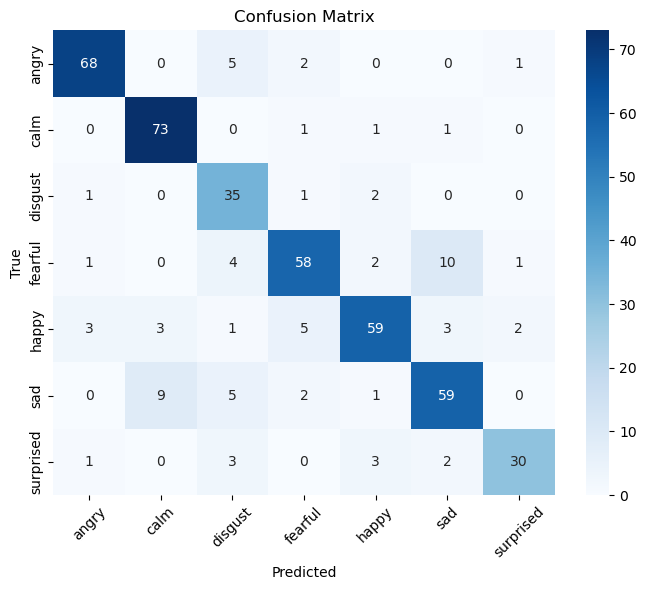

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
labels_str = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'sad', 'surprised']

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_str,
            yticklabels=labels_str)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [249]:
# Save the trained model
torch.save(model.state_dict(), 'final_emotion_model.pth')